Universidad Galileo

Statistical Learning I

PAPD - Sección V

Sergio José Barrios Martínez

Carnet No. 19012765

# Proyecto Final Statistical Learning 1
## Deployment, Inferencia y Predicción

Se utilizará el resultado del "ensemble learning" obtenido en el Proyecto, para una etapa de Deployment y Predicción.

Para ello se creará una función que realiza lo siguiente:
- Cargar los modelos seleccionados en la etapa de "ensemble".
- Formular una predicción (combinación de modelos) a partir de una observación (o colección de observaciones).
- Mostrar el Árbol de Decisión (interpretabilidad de este modelo).
- Mostrar la predicción Probabilística de los Modelos de Bayes y Regresión Logística.

Finalmente se muestra una prueba para 10 muestras aleatorias.


In [148]:
import numpy as np
import pandas as pd
from sklearn import tree
from joblib import load
import math
from scipy import stats
import graphviz
import pydotplus
from IPython.display import Image, display

## Importación de Modelos

In [149]:
modelo_DecisionTree = load('.\DecisionTreeModel\DT-maxdepth=20-minsamples=75.sav')
modelo_DecisionTree

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=20, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=75,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [150]:
modelo_SVM = load('.\SVMModel\SVM-regularizacion=0.3.sav')
modelo_SVM

SVC(C=0.3, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [151]:
modelo_NaiveBayes = load('.\BayesModel\Bayes-NumVariables=10.sav')
modelo_NaiveBayes.head()

,Feature,Valor,P(Valor|SI),P(Valor|NO),P(Valor),P(SI),P(NO)
0,SibSp,0,0.598930,0.731629,0.682,0.374,0.626
1,SibSp,1,0.342246,0.140575,0.216,0.374,0.626
2,SibSp,2,0.026738,0.044728,0.038,0.374,0.626
3,SibSp,8,0.000000,0.038339,0.024,0.374,0.626
4,SibSp,4,0.010695,0.022364,0.018,0.374,0.626


In [152]:
modelo_LogisticRegression = np.load('.\LogisticRegressionModel\LRegression-lr=0.0015-it=1000-bs=32-lambda=0.0001-L=2.0.npy')
modelo_LogisticRegression

array([[[-0.0385678 ],
        [-0.17683415],
        [-0.07526617],
        [-0.00326108],
        [-0.6302827 ],
        [ 0.06429784],
        [ 1.3637238 ],
        [ 0.18752721],
        [-0.07440362],
        [-0.13582933]]], dtype=float32)

#### Feature Engineering sobre Datos de Entrada a Naive-Bayes
El modelo de Naive-Bayes encontrado en la Parte I fue entrenado con un conjunto de datos transformados por medio de selección y transformación de features con Feature Engineering. Esta transformación hay que aplicarla igualmente a los datos sobre los cuales se desea predecir. Por este motivo se incluye una función "pipeline" que transforma los datos de entrada (un dataframe en pandas) para que se pueda realizar la predicción correctamente.

In [153]:
def predict_NaiveBayes(x_validacion,modelo):
    
    
    # Feature Engineering sobre Tensor de Entrada necesario por 
    # haber entrenado el modelo sobre un Tensor transformado
    X = x_validacion.copy()
    
    # Feature "Age"
    limites = np.linspace(0,100,10)
    categorias_Age = np.digitize(X["Age"], limites)
    X['categoria_age'] = categorias_Age

    # Feature "Fare"
    limites = np.linspace(0,50,10)
    categorias_Fare = np.digitize(X["Fare"], limites)
    X['categoria_fare'] = categorias_Fare

    # Eliminación de Features numéricas que se transformaron a categóricas
    X=X.drop(['Age', 'Fare'], axis=1)
   
    
    features = X.columns
    y_pred = np.ones(len(X))
    data_probabilistica = []
    
    for muestra in np.arange(0,len(X)):
        y_pred[muestra]=0
        probabilidad_SI=1.0
        probabilidad_NO=1.0

        for clase in features: # Para cada clase
            filtro = (modelo["Feature"]== clase) & (modelo["Valor"] == X.iloc[muestra][clase])

            # Encontrando "Likelihood" para la clase y el valor específico
            if np.sum(filtro)!= 0: # Naive Bayes solo puede predecir categorías previamente vistas
                probabilidad_SI = probabilidad_SI*modelo[filtro]["P(Valor|SI)"].iloc[0] #Probabilidad Condicional SI 
                probabilidad_NO = probabilidad_NO*modelo[filtro]["P(Valor|NO)"].iloc[0] #Probabilidad Condicional NO
            else:
                probabilidad_SI = 0.0 # Si la categoría no ha sido vista durante entrenamiento, no podrá predecirse
                probabilidad_NO = 0.0
                
        # Calculando Posterior
        probabilidad_SI = probabilidad_SI*modelo[filtro]["P(SI)"].iloc[0] # Multiplicando Condicionales por Prior SI
        probabilidad_NO = probabilidad_NO*modelo[filtro]["P(NO)"].iloc[0] # Multiplicando Condicionales por Prior NO
        
        if ((probabilidad_SI != 0.0) & (probabilidad_NO != 0.0)):
            probabilidad_TOTAL = probabilidad_SI + probabilidad_NO
            probabilidad_SI_final = probabilidad_SI/probabilidad_TOTAL
            probabilidad_NO_final = probabilidad_NO/probabilidad_TOTAL
        else:
            probabilidad_SI_final = 0.0
            probabilidad_NO_final = 0.0     
    
        # DataFrame para Interpretabilidad de Modelo Naive-Bayes
        data_probabilistica.append([np.around(probabilidad_SI_final*100,2),np.around(probabilidad_NO_final*100,2)])
                 
        # Predicción
        y_pred[muestra] = np.argmax([probabilidad_NO_final,probabilidad_SI_final])
    
    df = pd.DataFrame(data_probabilistica, columns = ['Probabilidad Sobrevivir (%)', 'Probabilidad No Sobrevivir (%)'])
    
    return (y_pred,df)

#### Predicción de LogisticRegression

In [154]:
def predict_LogisticRegression(x_validacion,modelo):
    
    X = x_validacion.copy()
    
    # Preparación de Matriz X para cálculo vectorizado en la forma Y=X*W para (Y=mX+b)
    unos = np.ones((np.shape(x_validacion)[0], 1)) 
    X = np.concatenate((X,unos),axis=1)

    # Logits
    logits = np.matmul(X,modelo[0])
    
    # Sigmoid para obtener predicción de categoría 
    y_pred = [np.around(1 / (1 + math.exp(-i))) for i in logits]
    
    return (y_pred)

In [188]:
def prediccion_ensemble(X):
    y_pred_DecisionTree = modelo_DecisionTree.predict(X)
    y_pred_SVM = modelo_SVM.predict(X)
    y_pred_NaiveBayes,df_Bayes = predict_NaiveBayes(X,modelo_NaiveBayes)
    y_pred_LogisticRegression = predict_LogisticRegression(X,modelo_LogisticRegression)
    
    # Interpretabilidad Modelo de Arbol de Decision
    print("Interpretabilidad Modelo Árbol de Decisión:")
    arbol_modelo1 = tree.export_graphviz(modelo_DecisionTree, out_file=None,
                               feature_names=X.columns,  
                               class_names=["survived","not survived"],  
                               filled=True, rounded=True,  
                              special_characters=True) 

    grafica_modelo1 = pydotplus.graph_from_dot_data(arbol_modelo1) 
    display(Image(grafica_modelo1.create_png()))
    
    # Predicción Probabilística de Modelo Naive-Bayes
    print("Predicción Probabilística Modelo Naive-Bayes")
    display(df_Bayes)
    
    # Predicción Probabilística de Modelo Logistic Regression
    print("Predicción Probabilística Modelo Logistic Regression (Sigmoid)")
    LR_SI = [100.0*p for p in y_pred_LogisticRegression]
    LR_NO = [100.0 - p for p in LR_SI]
    data_probabilisitica_LR = np.transpose(np.array([LR_SI,LR_NO]))
    #print(data_probabilisitica_LR)
    df_lr = pd.DataFrame(data_probabilisitica_LR, columns = ['Probabilidad Sobrevivir (%)', 'Probabilidad No Sobrevivir (%)'])
    display(df_lr)
    
   # print(y_pred_LogisticRegression)
    
    # Ensamble de Predicciones
    predicciones = []
    predicciones.append(y_pred_DecisionTree)
    predicciones.append(y_pred_SVM)
    predicciones.append(y_pred_NaiveBayes)
    predicciones.append(y_pred_LogisticRegression)
    predicciones=np.transpose(predicciones)
    
    # Votación Mayoritaria Utilizando Moda Vectorizada
    prediccion_final=stats.mode(predicciones,axis=1)
    
    # Creación de DataFrame con Resultados de Predicciones y Votación Mayoritaria
    data = np.concatenate((predicciones,prediccion_final[0],(prediccion_final[1]*100/4)),axis=1) 
    df_predicciones = pd.DataFrame(data, columns = ['DecisionTree', 'SVM','NaiveBayes','LogisticRegression',\
                                                    'MajorityVoting','%Voting']) 
    
    
    return(df_predicciones)

## Predicción

In [156]:
datos_titanic = pd.read_csv('data_titanic_proyecto.csv')
X=datos_titanic.head()

In [157]:
def pipeline(X_entrada):
    
    X=X_entrada.copy()
    # Creación de Feature "Deck"
    X["Deck"] = X["Cabin"].astype(str).str[0]
    
    # Mascaras para filtrar los faltantes de Cabina y las distintas clases de pasajeros
    filtro_faltantes_deck = X["Deck"] == 'n'
    filtro_lower = X["passenger_class"] == "Lower"
    filtro_middle = X["passenger_class"] == "Middle"
    filtro_upper = X["passenger_class"] == "Upper"

    # Creación de nueva feature "clase_cabina"
    clase_cabina = X["PassengerId"].copy()

    # Para los faltantes que estén en la clase de pasajero Upper, asignaremos
    # la clase de cabina 1, y tambien será la misma clase de cabina para las cabinas
    # "A", "B", "C", "D", "E", "T"
    clase_cabina[filtro_upper & filtro_faltantes_deck] = 1
    clase_cabina[ (X["Deck"] == "A") | (X["Deck"] == "B") 
                | (X["Deck"] == "C") | (X["Deck"] == "D")
                | (X["Deck"] == "E") | (X["Deck"] == "T")] = 1

    # Para los faltantes que estén en la clase de pasajero Middle, asignaremos
    # la clase de cabina 2, igualmente si está en la cabina "F"
    clase_cabina[filtro_middle & filtro_faltantes_deck] = 2
    clase_cabina[(X["Deck"] == "F")] = 2

    # Para los faltantes que estén en la clase de pasajero Lower, asignaremos
    # la clase de cabina 3, igualmente si está en la cabina "F"
    clase_cabina[filtro_lower & filtro_faltantes_deck] = 3
    clase_cabina[(X["Deck"] == "G")] = 3

    X["clase_cabina"]=clase_cabina 
    
    
    # Transformación de Variables Numéricas Continuas a Discretas
    
    #Datos numéricos para la variable "passenger_class"
    clase_lower = X["passenger_class"]=='Lower'
    clase_middle = X["passenger_class"]=='Middle'
    clase_upper = X["passenger_class"]=='Upper'
    clase = X["PassengerId"].copy()
    clase[clase_lower] = 1
    clase[clase_middle] = 2
    clase[clase_upper] = 3
    X["clase_pasajero"]=clase

    #Datos numéricos para la variable "passenger_sex"
    posiciones_male = X["passenger_sex"]=='M'
    posiciones_female = X["passenger_sex"]=='F'
    sex = X["PassengerId"].copy()
    sex[posiciones_male] = 1
    sex[posiciones_female] = 2
    X["sexo_pasajero"]=sex

    #Datos numéricos para la variable "Embarked"
    puerto_S = X["Embarked"]=='S'
    puerto_C = X["Embarked"]=='C'
    puerto_Q = X["Embarked"]=='Q'
    puerto = X["PassengerId"].copy()
    puerto[puerto_S] = 1
    puerto[puerto_C] = 2
    puerto[puerto_Q] = 3
    X["puerto"]=puerto

    # Datos numéricos para la variable "passenger_survived"
    posiciones_supervivientes=X["passenger_survived"]=='Y'
    posiciones_no_supervivientes=X["passenger_survived"]=='N'
    survived = X["PassengerId"].copy()
    survived[posiciones_supervivientes] = 1
    survived[posiciones_no_supervivientes] = 0
    X["sobreviviente"]=survived
    
    # Feature Frecuencia Ticket
    X['Frecuencia_Ticket'] = X.groupby('Ticket')['Ticket'].transform('count') 

    # Selección de Features Relevantes
    X_transformed = X[X.columns[[2,3,4,6,13,14,15,16,18]]]
    
    
    return(X_transformed)

In [158]:
x_transformado=pipeline(X)
x_transformado

,Age,SibSp,Parch,Fare,clase_cabina,clase_pasajero,sexo_pasajero,puerto,Frecuencia_Ticket
0,22.0,1,0,7.2500,3,1,1,1,1
1,38.0,1,0,71.2833,1,3,2,2,1
2,26.0,0,0,7.9250,3,1,2,1,1
3,35.0,1,0,53.1000,1,3,2,1,1
4,35.0,0,0,8.0500,3,1,1,1,1


## Función de Predicción

Se muestra como opera la función de predicción de acuerdo a los requisitos de interpretabilidad del Árbol de Decisión y las predicciones probabilísticas del modelo Naive-Bayes y Regresión-Logística

Interpretabilidad Modelo Árbol de Decisión:


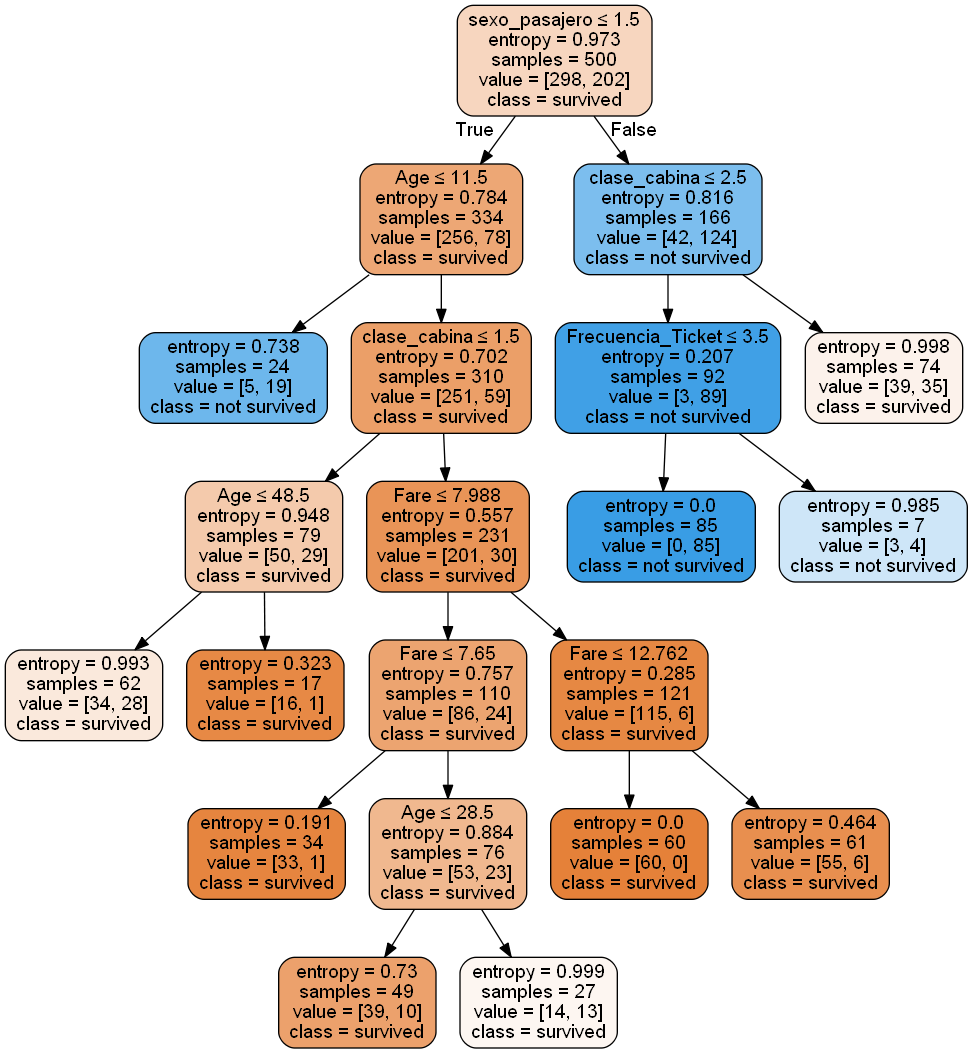

Predicción Probabilística Modelo Naive-Bayes


,Probabilidad Sobrevivir (%),Probabilidad No Sobrevivir (%)
0,3.88,96.12
1,99.08,0.92
2,12.11,87.89
3,97.84,2.16
4,1.44,98.56


Predicción Probabilística Modelo Logistic Regression (Sigmoid)


,Probabilidad Sobrevivir (%),Probabilidad No Sobrevivir (%)
0,0.0,100.0
1,100.0,0.0
2,0.0,100.0
3,100.0,0.0
4,0.0,100.0


In [189]:
prediccion_deployment=prediccion_ensemble(x_transformado)

In [190]:
prediccion_deployment

,DecisionTree,SVM,NaiveBayes,LogisticRegression,MajorityVoting,%Voting
0,0.0,0.0,0.0,0.0,0.0,100.0
1,1.0,1.0,1.0,1.0,1.0,100.0
2,0.0,1.0,0.0,0.0,0.0,75.0
3,1.0,1.0,1.0,1.0,1.0,100.0
4,0.0,0.0,0.0,0.0,0.0,100.0


### Prueba de Función de Predicción "Ensemble Learning" sobre 10 muestras Aleatorias distintas (una a una)

#### Prueba No. 1

In [192]:
X1=datos_titanic.sample(1)
X1

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived
586,587,"Jarvis, Mr. John Denzil",47.0,0,0,237565,15.0,NaN,S,Middle,M,N


In [194]:
X1_transformado = pipeline(X1)
X1_transformado

,Age,SibSp,Parch,Fare,clase_cabina,clase_pasajero,sexo_pasajero,puerto,Frecuencia_Ticket
586,47.0,0,0,15.0,2,2,1,1,1


Interpretabilidad Modelo Árbol de Decisión:


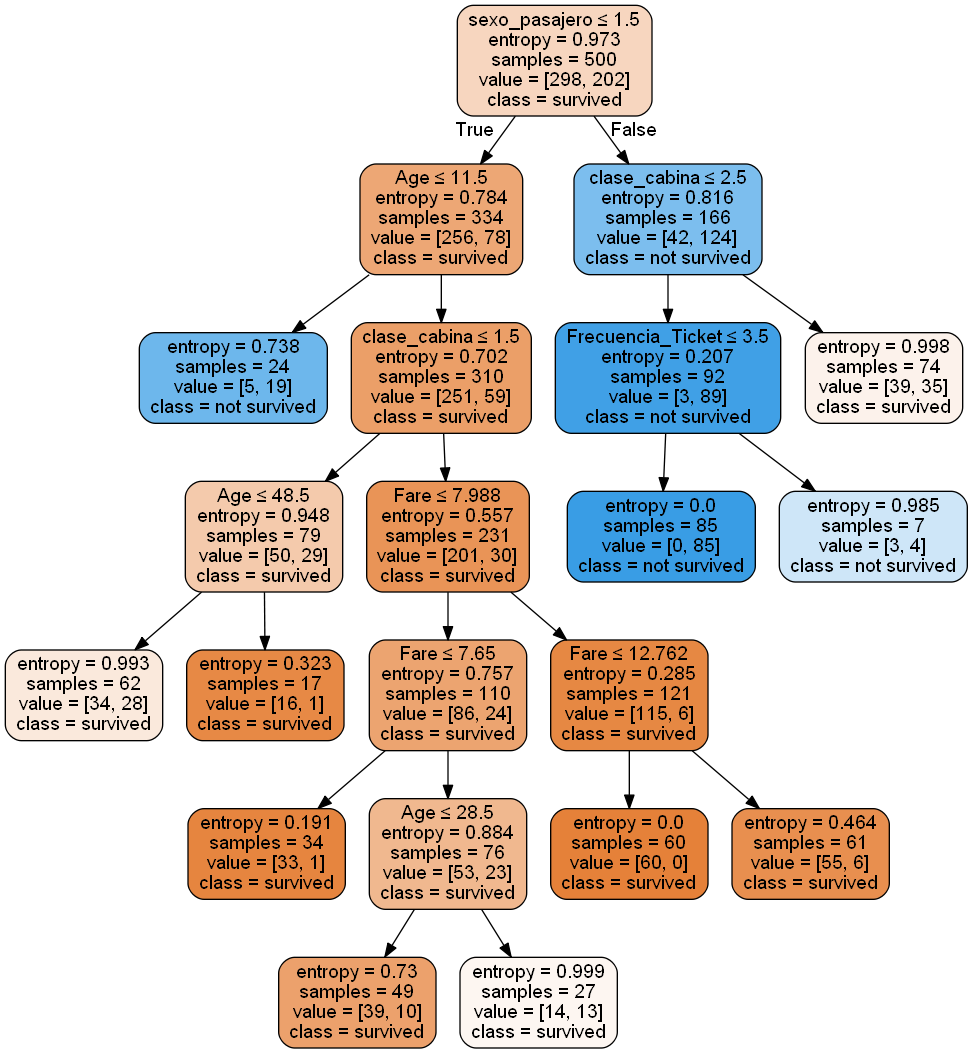

Predicción Probabilística Modelo Naive-Bayes


,Probabilidad Sobrevivir (%),Probabilidad No Sobrevivir (%)
0,16.78,83.22


Predicción Probabilística Modelo Logistic Regression (Sigmoid)


,Probabilidad Sobrevivir (%),Probabilidad No Sobrevivir (%)
0,0.0,100.0


In [199]:
prediccion_deployment1=prediccion_ensemble(X1_transformado)

In [200]:
prediccion_deployment1

,DecisionTree,SVM,NaiveBayes,LogisticRegression,MajorityVoting,%Voting
0,0.0,0.0,0.0,0.0,0.0,100.0


#### Prueba No. 2

In [202]:
X2=datos_titanic.sample(1)
X2

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived
352,353,"Elias, Mr. Tannous",15.0,1,1,2695,7.2292,NaN,C,Lower,M,N


In [203]:
X2_transformado = pipeline(X2)
X2_transformado

,Age,SibSp,Parch,Fare,clase_cabina,clase_pasajero,sexo_pasajero,puerto,Frecuencia_Ticket
352,15.0,1,1,7.2292,3,1,1,2,1


Interpretabilidad Modelo Árbol de Decisión:


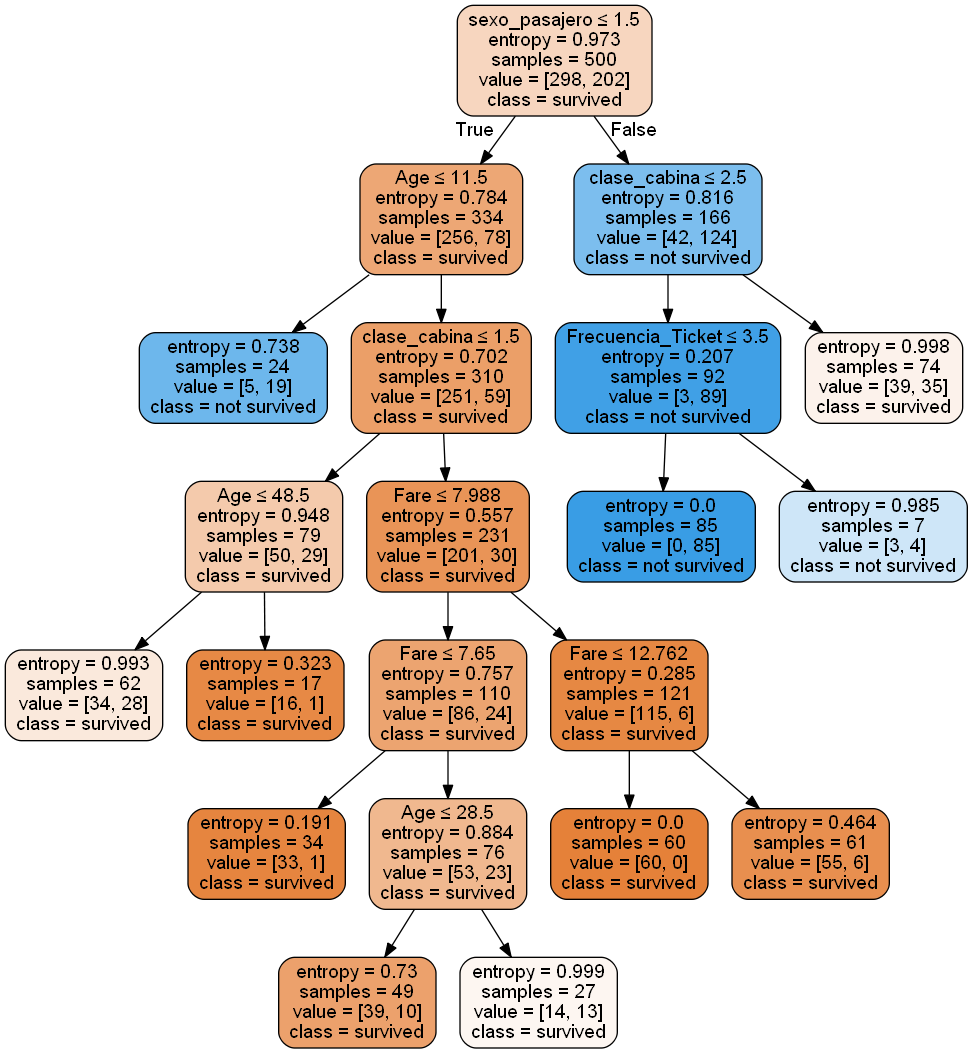

Predicción Probabilística Modelo Naive-Bayes


,Probabilidad Sobrevivir (%),Probabilidad No Sobrevivir (%)
0,17.39,82.61


Predicción Probabilística Modelo Logistic Regression (Sigmoid)


,Probabilidad Sobrevivir (%),Probabilidad No Sobrevivir (%)
0,0.0,100.0


In [204]:
prediccion_deployment2=prediccion_ensemble(X2_transformado)

In [206]:
prediccion_deployment2

,DecisionTree,SVM,NaiveBayes,LogisticRegression,MajorityVoting,%Voting
0,0.0,0.0,0.0,0.0,0.0,100.0


#### Prueba No. 3

In [210]:
X3=datos_titanic.sample(1)
X3

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived
691,692,"Karun, Miss. Manca",4.0,0,1,349256,13.4167,NaN,C,Lower,F,Y


In [211]:
X3_transformado = pipeline(X3)
X3_transformado

,Age,SibSp,Parch,Fare,clase_cabina,clase_pasajero,sexo_pasajero,puerto,Frecuencia_Ticket
691,4.0,0,1,13.4167,3,1,2,2,1


Interpretabilidad Modelo Árbol de Decisión:


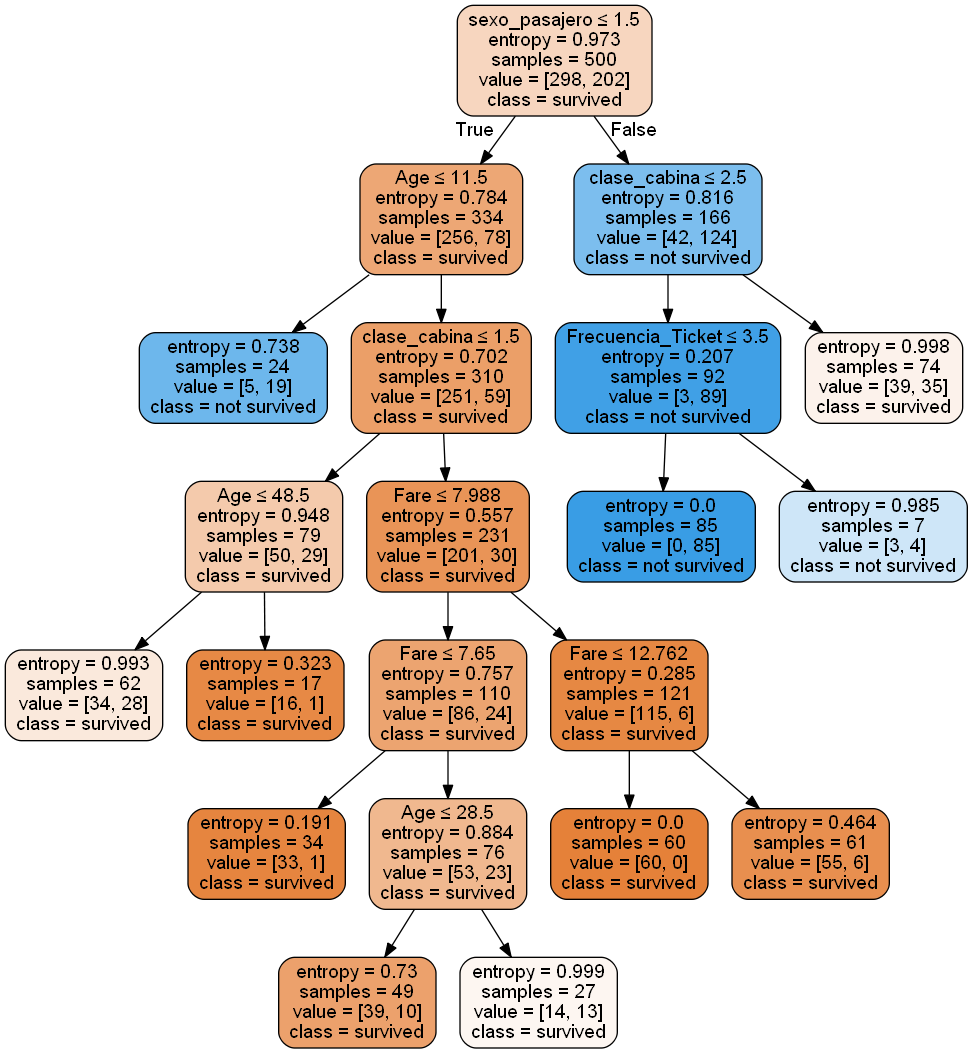

Predicción Probabilística Modelo Naive-Bayes


,Probabilidad Sobrevivir (%),Probabilidad No Sobrevivir (%)
0,93.18,6.82


Predicción Probabilística Modelo Logistic Regression (Sigmoid)


,Probabilidad Sobrevivir (%),Probabilidad No Sobrevivir (%)
0,100.0,0.0


In [212]:
prediccion_deployment3=prediccion_ensemble(X3_transformado)

In [213]:
prediccion_deployment3

,DecisionTree,SVM,NaiveBayes,LogisticRegression,MajorityVoting,%Voting
0,0.0,1.0,1.0,1.0,1.0,75.0


#### Prueba No. 4

In [214]:
X4=datos_titanic.sample(1)
X4

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived
131,132,"Coelho, Mr. Domingos Fernandeo",20.0,0,0,SOTON/O.Q. 3101307,7.05,NaN,S,Lower,M,N


In [215]:
X4_transformado = pipeline(X4)
X4_transformado

,Age,SibSp,Parch,Fare,clase_cabina,clase_pasajero,sexo_pasajero,puerto,Frecuencia_Ticket
131,20.0,0,0,7.05,3,1,1,1,1


Interpretabilidad Modelo Árbol de Decisión:


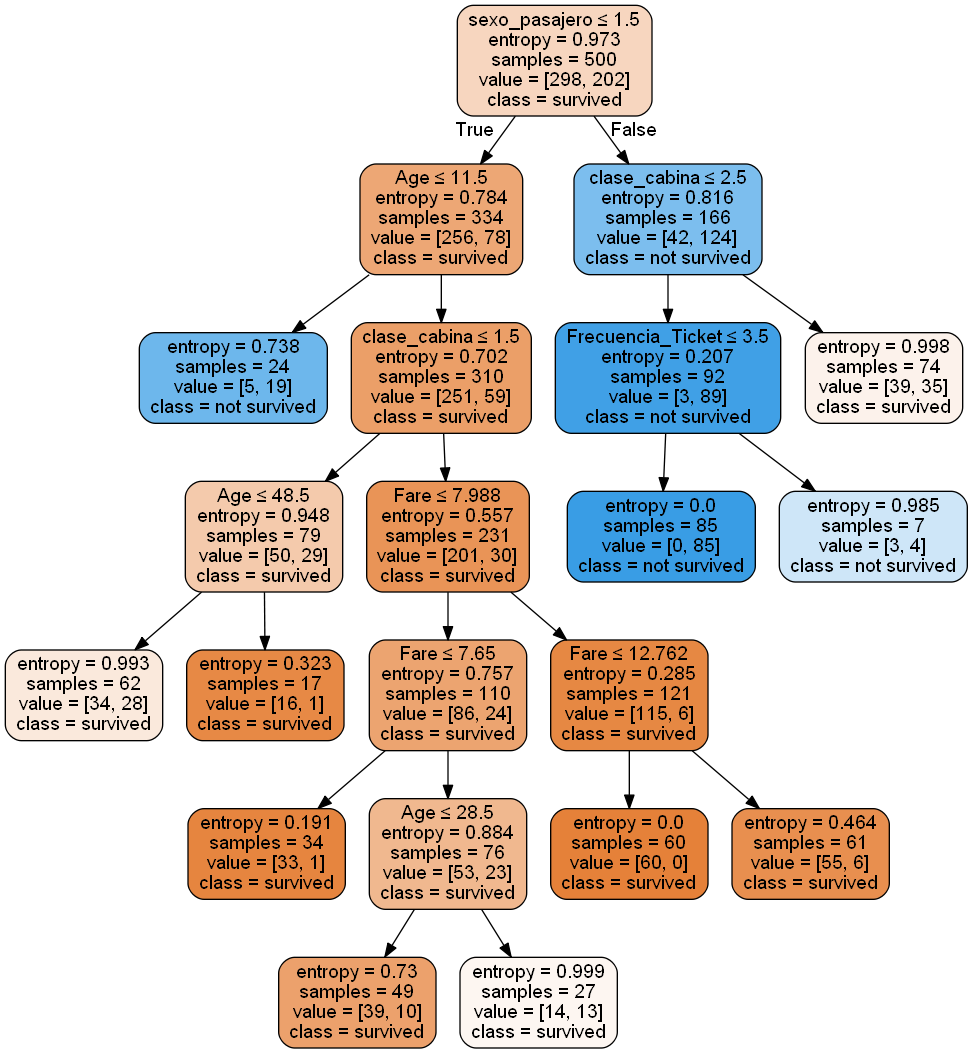

Predicción Probabilística Modelo Naive-Bayes


,Probabilidad Sobrevivir (%),Probabilidad No Sobrevivir (%)
0,1.34,98.66


Predicción Probabilística Modelo Logistic Regression (Sigmoid)


,Probabilidad Sobrevivir (%),Probabilidad No Sobrevivir (%)
0,0.0,100.0


In [216]:
prediccion_deployment4=prediccion_ensemble(X4_transformado)

In [217]:
prediccion_deployment4

,DecisionTree,SVM,NaiveBayes,LogisticRegression,MajorityVoting,%Voting
0,0.0,0.0,0.0,0.0,0.0,100.0


#### Prueba No. 5

In [220]:
X5=datos_titanic.sample(1)
X5

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived
432,433,"Louch, Mrs. Charles Alexander (Alice Adelaide ...",42.0,1,0,SC/AH 3085,26.0,NaN,S,Middle,F,Y


In [221]:
X5_transformado = pipeline(X5)
X5_transformado

,Age,SibSp,Parch,Fare,clase_cabina,clase_pasajero,sexo_pasajero,puerto,Frecuencia_Ticket
432,42.0,1,0,26.0,2,2,2,1,1


Interpretabilidad Modelo Árbol de Decisión:


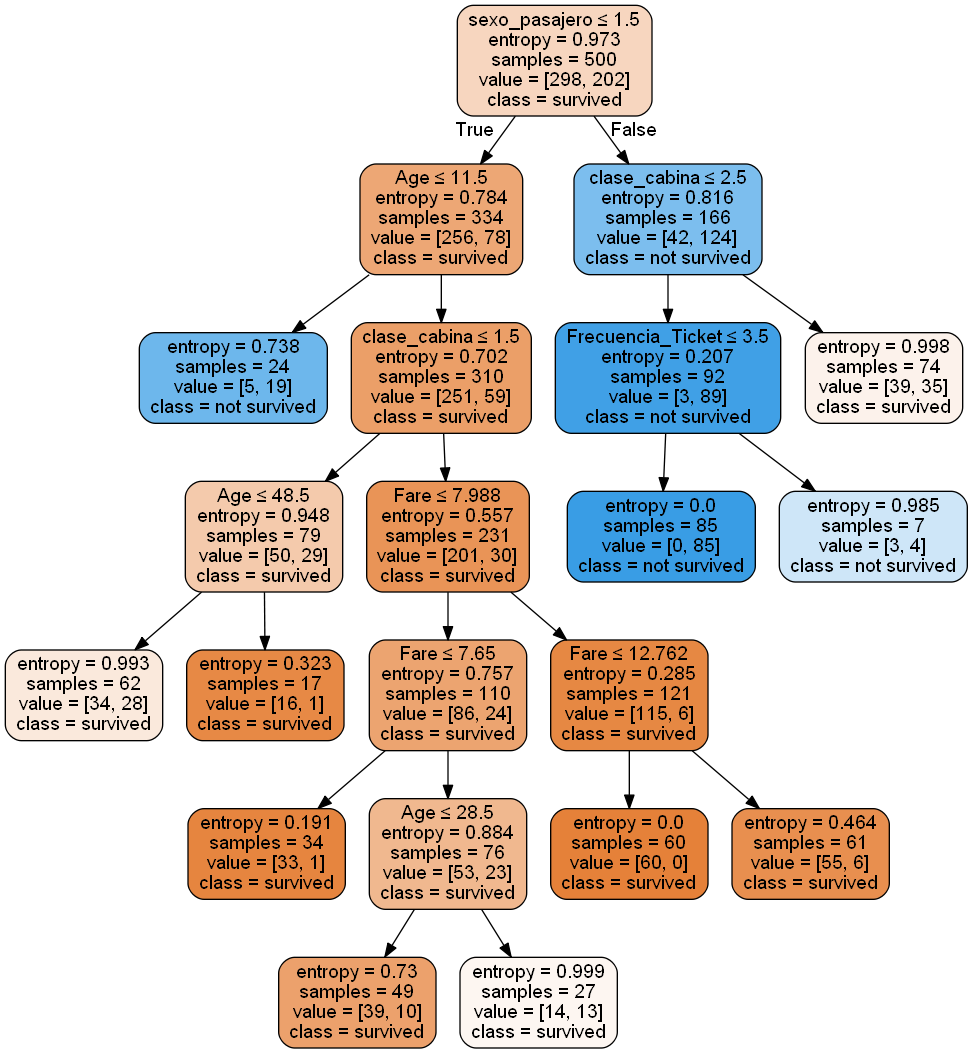

Predicción Probabilística Modelo Naive-Bayes


,Probabilidad Sobrevivir (%),Probabilidad No Sobrevivir (%)
0,85.76,14.24


Predicción Probabilística Modelo Logistic Regression (Sigmoid)


,Probabilidad Sobrevivir (%),Probabilidad No Sobrevivir (%)
0,0.0,100.0


In [222]:
prediccion_deployment5=prediccion_ensemble(X5_transformado)

In [223]:
prediccion_deployment5

,DecisionTree,SVM,NaiveBayes,LogisticRegression,MajorityVoting,%Voting
0,1.0,1.0,1.0,0.0,1.0,75.0


#### Prueba No. 6

In [224]:
X6=datos_titanic.sample(1)
X6

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived
70,71,"Jenkin, Mr. Stephen Curnow",32.0,0,0,C.A. 33111,10.5,NaN,S,Middle,M,N


In [225]:
X6_transformado = pipeline(X6)
X6_transformado

,Age,SibSp,Parch,Fare,clase_cabina,clase_pasajero,sexo_pasajero,puerto,Frecuencia_Ticket
70,32.0,0,0,10.5,2,2,1,1,1


Interpretabilidad Modelo Árbol de Decisión:


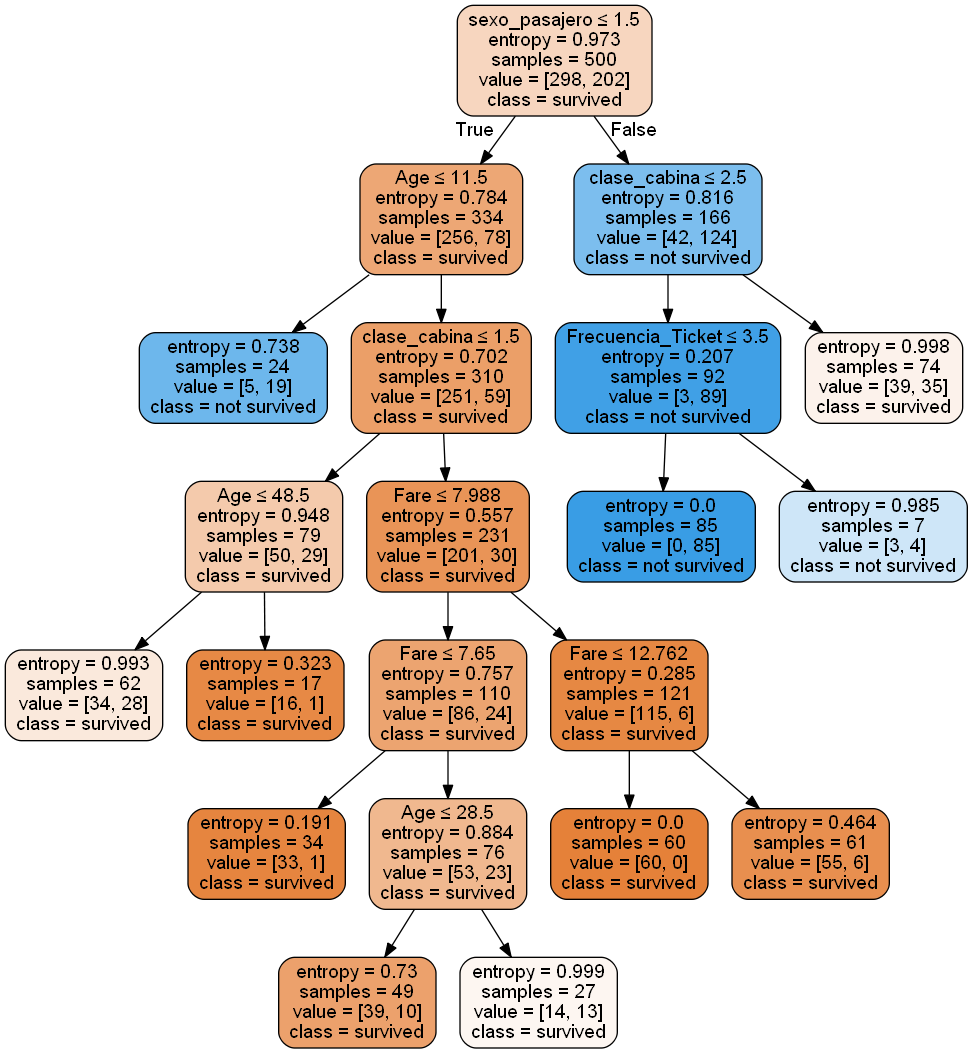

Predicción Probabilística Modelo Naive-Bayes


,Probabilidad Sobrevivir (%),Probabilidad No Sobrevivir (%)
0,3.31,96.69


Predicción Probabilística Modelo Logistic Regression (Sigmoid)


,Probabilidad Sobrevivir (%),Probabilidad No Sobrevivir (%)
0,0.0,100.0


In [226]:
prediccion_deployment6=prediccion_ensemble(X6_transformado)

In [227]:
prediccion_deployment6

,DecisionTree,SVM,NaiveBayes,LogisticRegression,MajorityVoting,%Voting
0,0.0,0.0,0.0,0.0,0.0,100.0


#### Prueba No. 7

In [230]:
X7=datos_titanic.sample(1)
X7

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived
323,324,"Caldwell, Mrs. Albert Francis (Sylvia Mae Harb...",22.0,1,1,248738,29.0,NaN,S,Middle,F,Y


In [231]:
X7_transformado = pipeline(X7)
X7_transformado

,Age,SibSp,Parch,Fare,clase_cabina,clase_pasajero,sexo_pasajero,puerto,Frecuencia_Ticket
323,22.0,1,1,29.0,2,2,2,1,1


Interpretabilidad Modelo Árbol de Decisión:


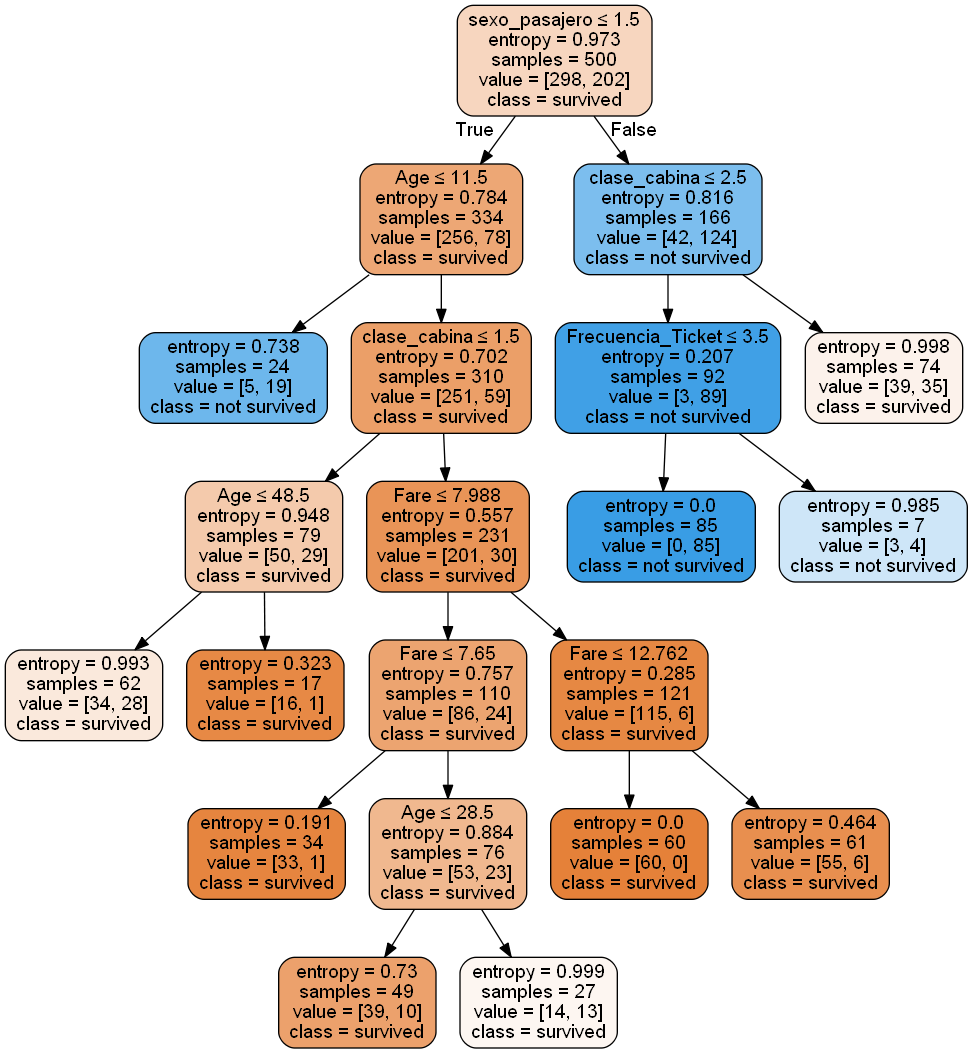

Predicción Probabilística Modelo Naive-Bayes


,Probabilidad Sobrevivir (%),Probabilidad No Sobrevivir (%)
0,90.63,9.37


Predicción Probabilística Modelo Logistic Regression (Sigmoid)


,Probabilidad Sobrevivir (%),Probabilidad No Sobrevivir (%)
0,100.0,0.0


In [232]:
prediccion_deployment7=prediccion_ensemble(X7_transformado)

In [233]:
prediccion_deployment7

,DecisionTree,SVM,NaiveBayes,LogisticRegression,MajorityVoting,%Voting
0,1.0,1.0,1.0,1.0,1.0,100.0


#### Prueba No. 8

In [234]:
X8=datos_titanic.sample(1)
X8

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived
248,249,"Beckwith, Mr. Richard Leonard",37.0,1,1,11751,52.5542,D35,S,Upper,M,Y


In [235]:
X8_transformado = pipeline(X3)
X8_transformado

,Age,SibSp,Parch,Fare,clase_cabina,clase_pasajero,sexo_pasajero,puerto,Frecuencia_Ticket
691,4.0,0,1,13.4167,3,1,2,2,1


Interpretabilidad Modelo Árbol de Decisión:


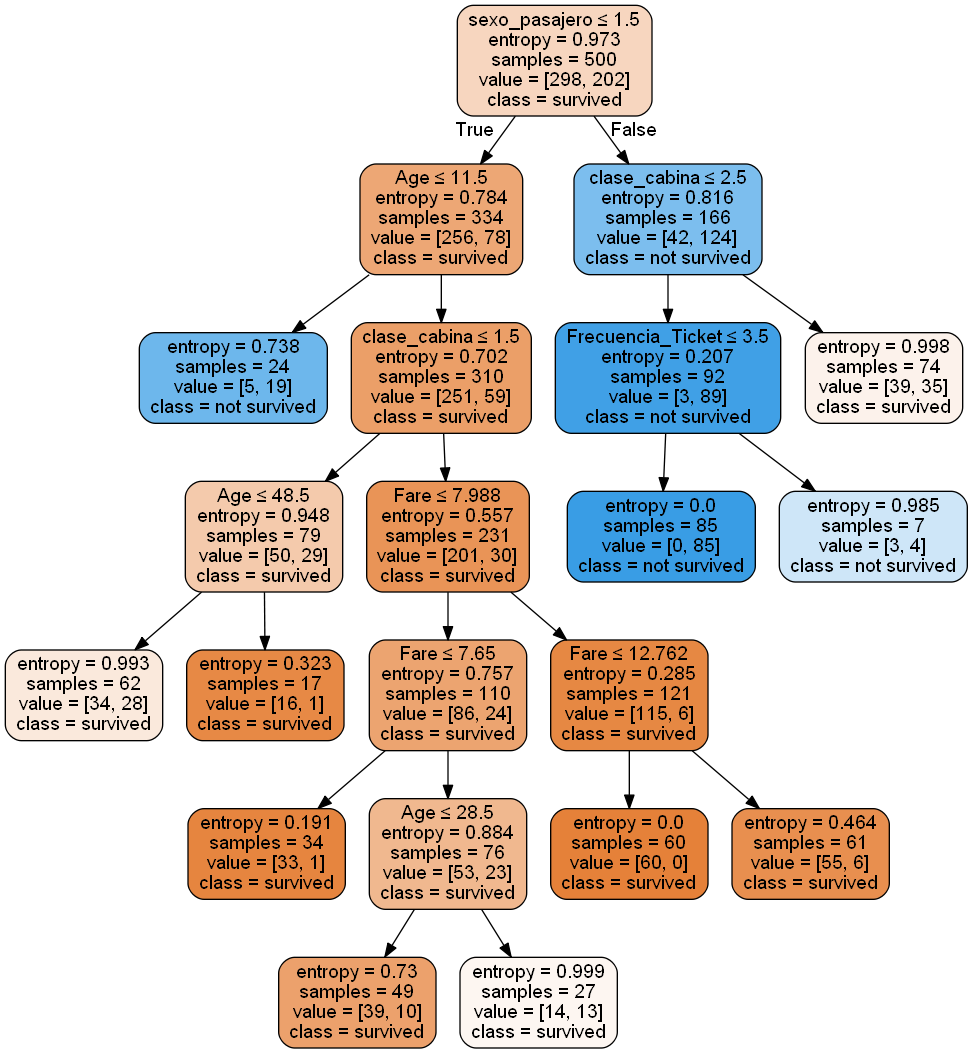

Predicción Probabilística Modelo Naive-Bayes


,Probabilidad Sobrevivir (%),Probabilidad No Sobrevivir (%)
0,93.18,6.82


Predicción Probabilística Modelo Logistic Regression (Sigmoid)


,Probabilidad Sobrevivir (%),Probabilidad No Sobrevivir (%)
0,100.0,0.0


In [236]:
prediccion_deployment8=prediccion_ensemble(X8_transformado)

In [237]:
prediccion_deployment8

,DecisionTree,SVM,NaiveBayes,LogisticRegression,MajorityVoting,%Voting
0,0.0,1.0,1.0,1.0,1.0,75.0


#### Prueba No. 9

In [239]:
X9=datos_titanic.sample(1)
X9

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived
889,890,"Behr, Mr. Karl Howell",26.0,0,0,111369,30.0,C148,C,Upper,M,Y


In [240]:
X9_transformado = pipeline(X9)
X9_transformado

,Age,SibSp,Parch,Fare,clase_cabina,clase_pasajero,sexo_pasajero,puerto,Frecuencia_Ticket
889,26.0,0,0,30.0,1,3,1,2,1


Interpretabilidad Modelo Árbol de Decisión:


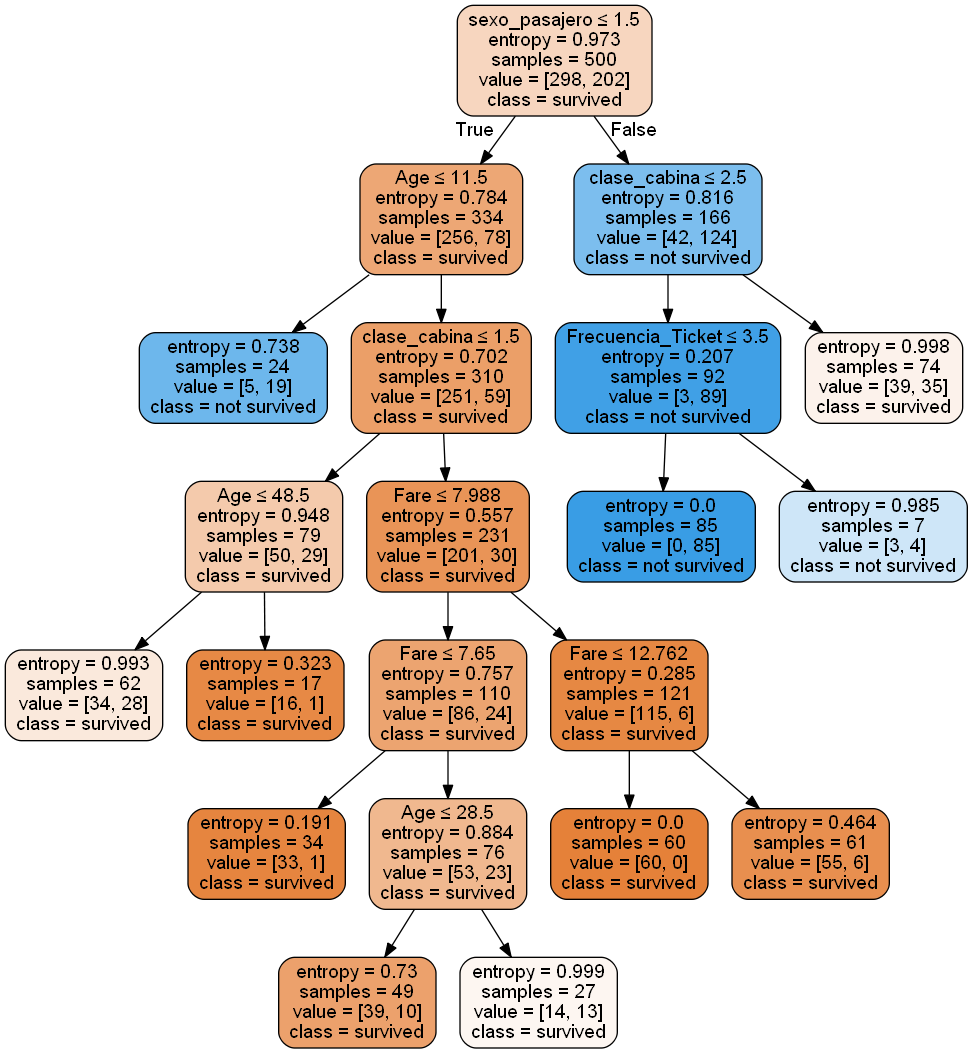

Predicción Probabilística Modelo Naive-Bayes


,Probabilidad Sobrevivir (%),Probabilidad No Sobrevivir (%)
0,42.5,57.5


Predicción Probabilística Modelo Logistic Regression (Sigmoid)


,Probabilidad Sobrevivir (%),Probabilidad No Sobrevivir (%)
0,0.0,100.0


In [241]:
prediccion_deployment9=prediccion_ensemble(X9_transformado)

In [242]:
prediccion_deployment9

,DecisionTree,SVM,NaiveBayes,LogisticRegression,MajorityVoting,%Voting
0,0.0,0.0,0.0,0.0,0.0,100.0


#### Prueba No. 10

In [243]:
X10=datos_titanic.sample(1)
X10

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived
777,778,"Emanuel, Miss. Virginia Ethel",5.0,0,0,364516,12.475,NaN,S,Lower,F,Y


In [246]:
X10_transformado = pipeline(X10)
X10_transformado

,Age,SibSp,Parch,Fare,clase_cabina,clase_pasajero,sexo_pasajero,puerto,Frecuencia_Ticket
777,5.0,0,0,12.475,3,1,2,1,1


Interpretabilidad Modelo Árbol de Decisión:


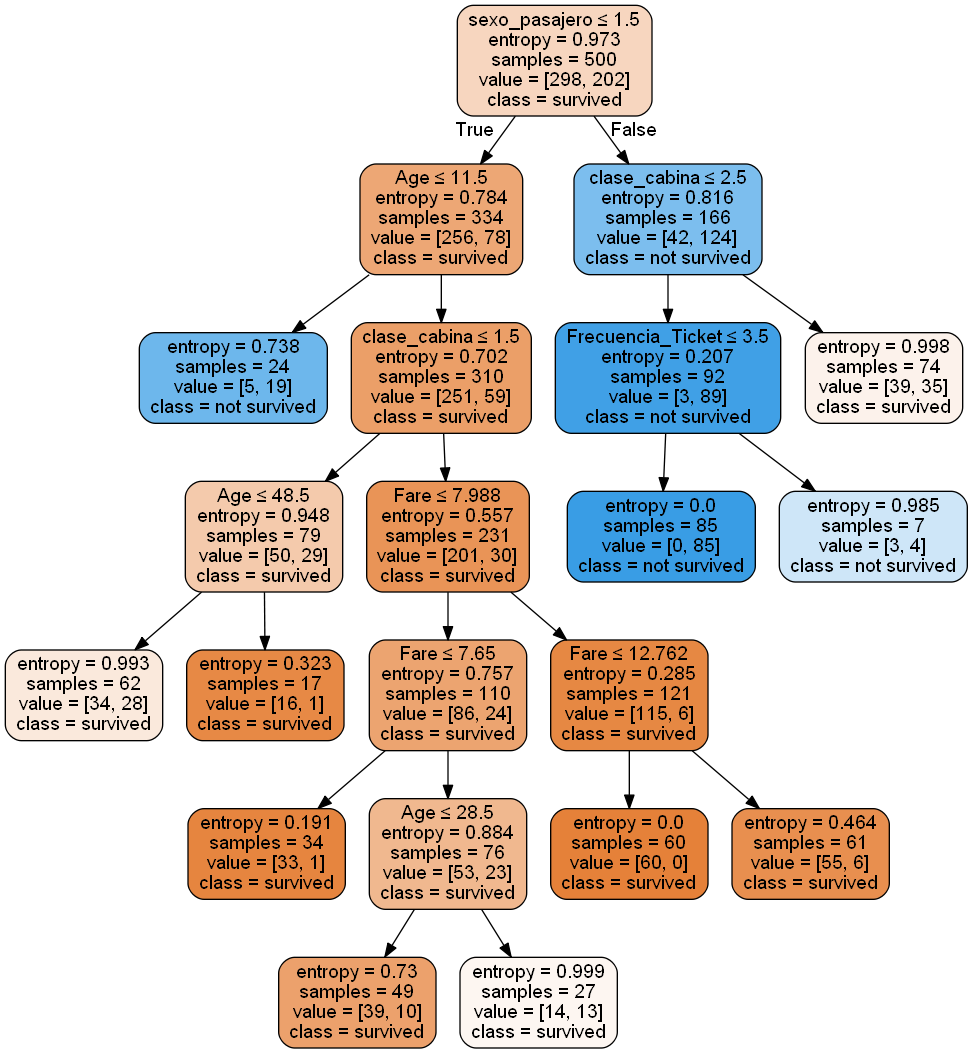

Predicción Probabilística Modelo Naive-Bayes


,Probabilidad Sobrevivir (%),Probabilidad No Sobrevivir (%)
0,93.18,6.82


Predicción Probabilística Modelo Logistic Regression (Sigmoid)


,Probabilidad Sobrevivir (%),Probabilidad No Sobrevivir (%)
0,100.0,0.0


In [245]:
prediccion_deployment10=prediccion_ensemble(X10_transformado)

In [247]:
prediccion_deployment10

,DecisionTree,SVM,NaiveBayes,LogisticRegression,MajorityVoting,%Voting
0,0.0,1.0,1.0,1.0,1.0,75.0
